# Analysis of a two-phase (phase separated) simulation

In this previous example, we analyzed a simulation conducted above the critical temperature.
In this tutorial, we now consider an LJ simulation with potentially two phases at $T^*=1.2$.

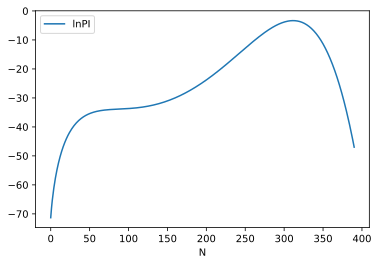

In [1]:
import sys
import numpy as np
import pandas as pd
import feasst
sys.path.insert(0, feasst.install_dir() + '/plugin/flat_histogram/tutorial/')
import fh

# load the data into the criteria object
dfsrsw = pd.read_csv(feasst.install_dir() + "/plugin/flat_histogram/test/data/stat120.csv")
criteria = fh.criteria_flathist(temperature=1.2,
                                chemical_potential=-2.902929,
                                macro_min=dfsrsw["N"].iloc[0],
                                macro_max=dfsrsw["N"].iloc[-1])
criteria.set_ln_prob(feasst.LnProbability(feasst.DoubleVector(dfsrsw["lnPI"])))

# plot macrostate and energy
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
ax = dfsrsw.plot('N', 'lnPI')

Note that this macrostate distribution may contain a second maximum depending on the value of the chemical potential.
But at the chemical potential simulated, the low density phase is unstable and there is no minimum.

In [2]:
assert(len(criteria.bias().ln_prob().minima()) == 0)

However, a minima appears after reweighting to a lower chemical potential. 

Text(200, -40, 'high density phase\n(more probable)')

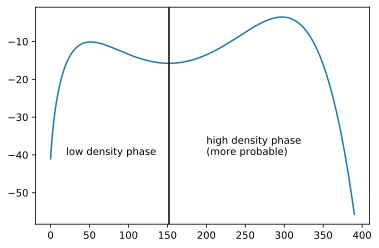

In [3]:
lnpirw = criteria.reweight(delta_conjugate=-0.1)
plt.plot(lnpirw.values())
minima = lnpirw.minima()
assert(len(minima) == 1 and minima[0] == 152)
plt.gca().axvline(minima[0], color='black')
plt.text(20, -40, 'low density phase')
plt.text(200, -40, 'high density phase\n(more probable)')

Find the chemical potential at phase equilibrium subject to the constraint that the probability of observing the two phases are equal.

Text(225, -40, 'saturated liquid')

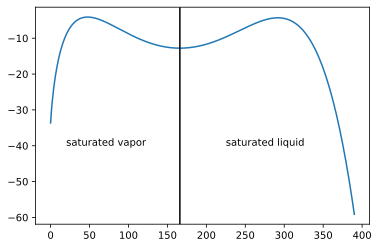

In [4]:
def objective(criteria, beta_mu_rw):
    delta_conjugate = beta_mu_rw - criteria.beta_mu()
    ln_prob_rw = criteria.reweight(delta_conjugate)
    return ln_prob_rw.saturation_objective(delta_conjugate)

from scipy.optimize import minimize
res = minimize(lambda beta_mu_rw: objective(criteria, beta_mu_rw[0]), -1, tol=1e-8)
mu_saturation = res["x"][-1]/criteria.beta()
delta_conjugate = criteria.beta()*mu_saturation - criteria.beta_mu()
criteria.set_chemical_potential(mu_saturation)
criteria.set_ln_prob(criteria.reweight(delta_conjugate))

plt.plot(criteria.bias().ln_prob().values())
plt.gca().axvline(criteria.bias().ln_prob().minima()[0], color='black')
plt.text(20, -40, 'saturated vapor')
plt.text(225, -40, 'saturated liquid')

Compare chemical potential and equilibrium properties with published results.

https://www.nist.gov/mml/csd/chemical-informatics-research-group/sat-tmmc-liquid-vapor-coexistence-properties-long-range

In [5]:
assert(abs(-3.0562684035569383 - criteria.chemical_potential()) < 1e-9)
mins = criteria.bias().ln_prob().minima()
assert(len(mins) == 1 and mins[0] == 166)

# pressure
volume = 8**3
assert(abs(0.07722559602858005 - criteria.pressure(volume, 0)) < 1e-9)

# pressure of both phases are equivalent
assert(abs(criteria.pressure(volume, 0) - criteria.pressure(volume, 1)) < 1e-7)

# density of vapor
assert(abs(0.1003523021979188 - criteria.average_macrostate(0)/volume) < 1e-15)

# density of liquid
assert(abs(0.5631867734067794 - criteria.average_macrostate(1)/volume) < 1e-15)